# This is the submission Notebook of Team Sigmoid Freud 
by Qianjing, Danie, Jacob, Fan, Jan

## Download the data, import necessary packages and load the data into DataFrames

In [35]:
# Demonstration data used in this excercise is already preprocessed and split into
# training, validation, and test sets

# Use wget to download the data stored in csv format.
import itertools

# Define what files to download; download all of the preprocessed data
# Note that the data are already split into Train, Validation, and Test sets.
# The predictor data are denoted with 'X', the target by 'y'
data_download = {}
data_download["window_size"] = [5, 15]
data_download["data_type"] = ["train", "valid", "test"]
data_download["predictor_or_target"] = ["X", "y"]

# Prepare the combinations of the window sizes and the data types
keys, values = zip(*data_download.items())
data_download_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
display('The kind of data to be downloaded:', data_download_combinations)

print("Downloading started...")
for data_download_param in data_download_combinations:
  file_to_download = "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_{0}_time_encoding_True/{1}_{2}_window_size_{0}_time_encoding_True.csv"\
                     .format(data_download_param["window_size"], data_download_param["predictor_or_target"], data_download_param["data_type"])

  # the actual downloading
  !wget "$file_to_download"

print("Downloading has finished")

'The kind of data to be downloaded:'

[{'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 15}]

--2021-10-28 09:45:21--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/X_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)... 52.219.170.26
Connecting to frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)|52.219.170.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53997719 (51M) [text/csv]
Saving to: ‘X_train_window_size_5_time_encoding_True.csv’

X_train_window_size 100%[===================>]  51.50M  20.4MB/s    in 2.5s    

2021-10-28 09:45:24 (20.4 MB/s) - ‘X_train_window_size_5_time_encoding_True.csv’ saved [53997719/53997719]

--2021-10-28 09:45:24--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/y_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-sch

In [ ]:
#This imports all necessary packages for our tasks
import pandas as pd
import numpy as np

#Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#Import necessary ml packages
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

#Import necessary Deep Learning
import tensorflow as tf
import tensorflow.keras as k 
from tensorflow.keras.layers import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the dataset with a sliding window of 5
X_train_window_size_5 = pd.read_csv('X_train_window_size_5_time_encoding_True.csv')
X_valid_window_size_5 = pd.read_csv('X_valid_window_size_5_time_encoding_True.csv')
X_test_window_size_5 = pd.read_csv('X_test_window_size_5_time_encoding_True.csv')
y_train_window_size_5 = pd.read_csv('y_train_window_size_5_time_encoding_True.csv')
y_valid_window_size_5 = pd.read_csv('y_valid_window_size_5_time_encoding_True.csv')
y_test_window_size_5 = pd.read_csv('y_test_window_size_5_time_encoding_True.csv')

# Exploratory Data Analysis (EDA)

## Helper functions for plotting

In [3]:
#First create our helper models to plot our analysis
def plot_subplots(dataframe: pd.DataFrame, title: str):
    """
    Draws one subplot for each of the columns in the DataFrame.
    """
    
    fig, axes = plt.subplots(nrows=len(dataframe.columns), figsize=(20,20))
    labels = list(dataframe.columns)

    for idx, row in enumerate(axes):
        y = dataframe.iloc[:, idx]
        row.plot(y, label=y.name)
        row.set_ylabel(labels[idx])

    fig.set_facecolor("grey")
    fig.suptitle(title, size=15, y=0.9)
    plt.show()

In [4]:
def plot_subplots_wrapper(
    dataframe: pd.DataFrame,
    title: str,
    labels: list = ["open", "high", "low", "close", "volume", "minutes"]
    ):
    """
    Calls the 'plot_subplots' function for each label provided in labels and selects columns that start with the label.
    """

    #df = dataframe.copy()
    for label in labels:
        print(f"Plots for {label}:")
        title = title + f" {label}"
        plot_subplots(dataframe.loc[:,dataframe.columns.str.startswith(label)], title)

### Get a basic understanding of the data

In [5]:
#Starting with our basic analysis for our data with a sliding winwow of 5
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

In [6]:
#Lets renae our columns so we actually understand columns with name 1 - 23
labels = ["open", "high", "low", "close", "volume", "minutes"]
new_cols = list(X_train_window_size_5.columns[:17])
for i in range(4, 0, -1):
    for label in labels:
        new_cols.append(label+f"_{i}_{i-1}")

X_train_5_original = X_train_window_size_5.copy()
X_train_window_size_5.columns = new_cols

In [7]:
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

In [8]:
X_train_window_size_5.head(5)

,total_hours,dlvry_weekend,dlvry_bank_holiday,dlvry_day_sin,dlvry_day_cos,dlvry_weekday_sin,dlvry_weekday_cos,dlvry_hour_sin,dlvry_hour_cos,lasttrade_weekend,...,low_2_1,close_2_1,volume_2_1,minutes_2_1,open_1_0,high_1_0,low_1_0,close_1_0,volume_1_0,minutes_1_0
0,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,...,5.39,5.41,187.7,480.0,4.41,-0.21,1.30,-1.31,-18.2,420.0
1,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,...,1.30,-1.31,-18.2,420.0,-0.31,-0.20,-0.66,-3.18,-78.3,360.0
2,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,...,-0.66,-3.18,-78.3,360.0,-3.49,-2.59,-7.97,-3.21,796.3,300.0
3,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,...,-7.97,-3.21,796.3,300.0,-2.90,-1.69,2.44,-0.01,-355.6,240.0
4,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,...,2.44,-0.01,-355.6,240.0,-0.70,-1.11,-1.11,-2.69,53.3,180.0


## This plots how many rows per contarct are and aggregates them

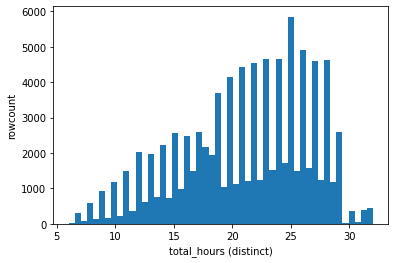

In [9]:
#This distribution show how many rows
X_train_window_size_5_grouped = X_train_window_size_5.groupby("total_hours").size().reset_index()
X_train_window_size_5_grouped.rename(columns={0: "rowcount"}, inplace=True)

plt.hist(X_train_window_size_5["total_hours"], label="rowcount", bins=50)
plt.xlabel("total_hours (distinct)")
plt.ylabel("rowcount")
plt.show()

## Candle Features 

Plots for open:


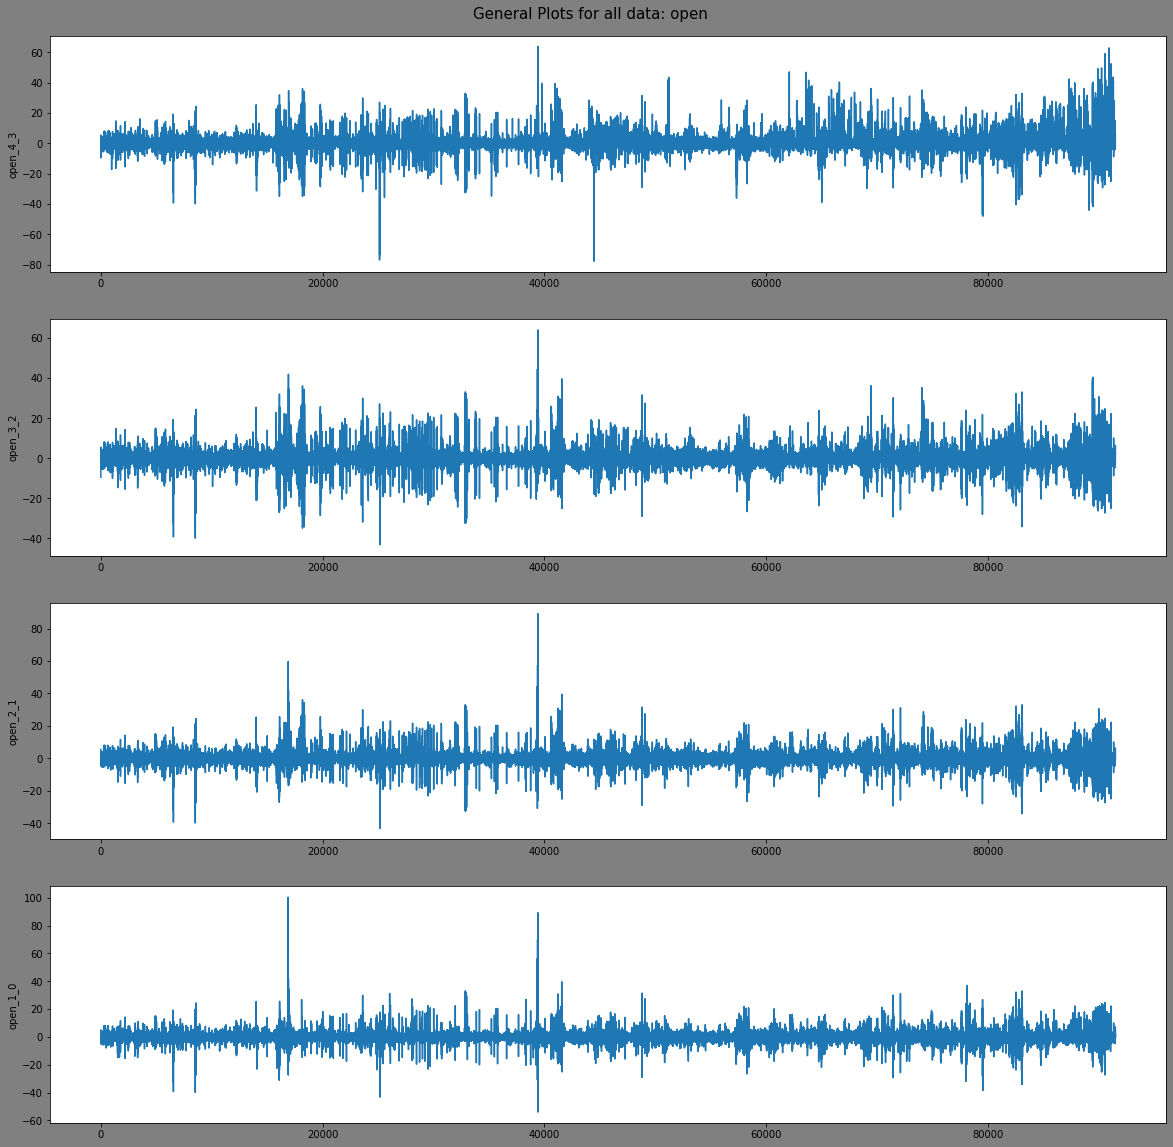

Plots for high:


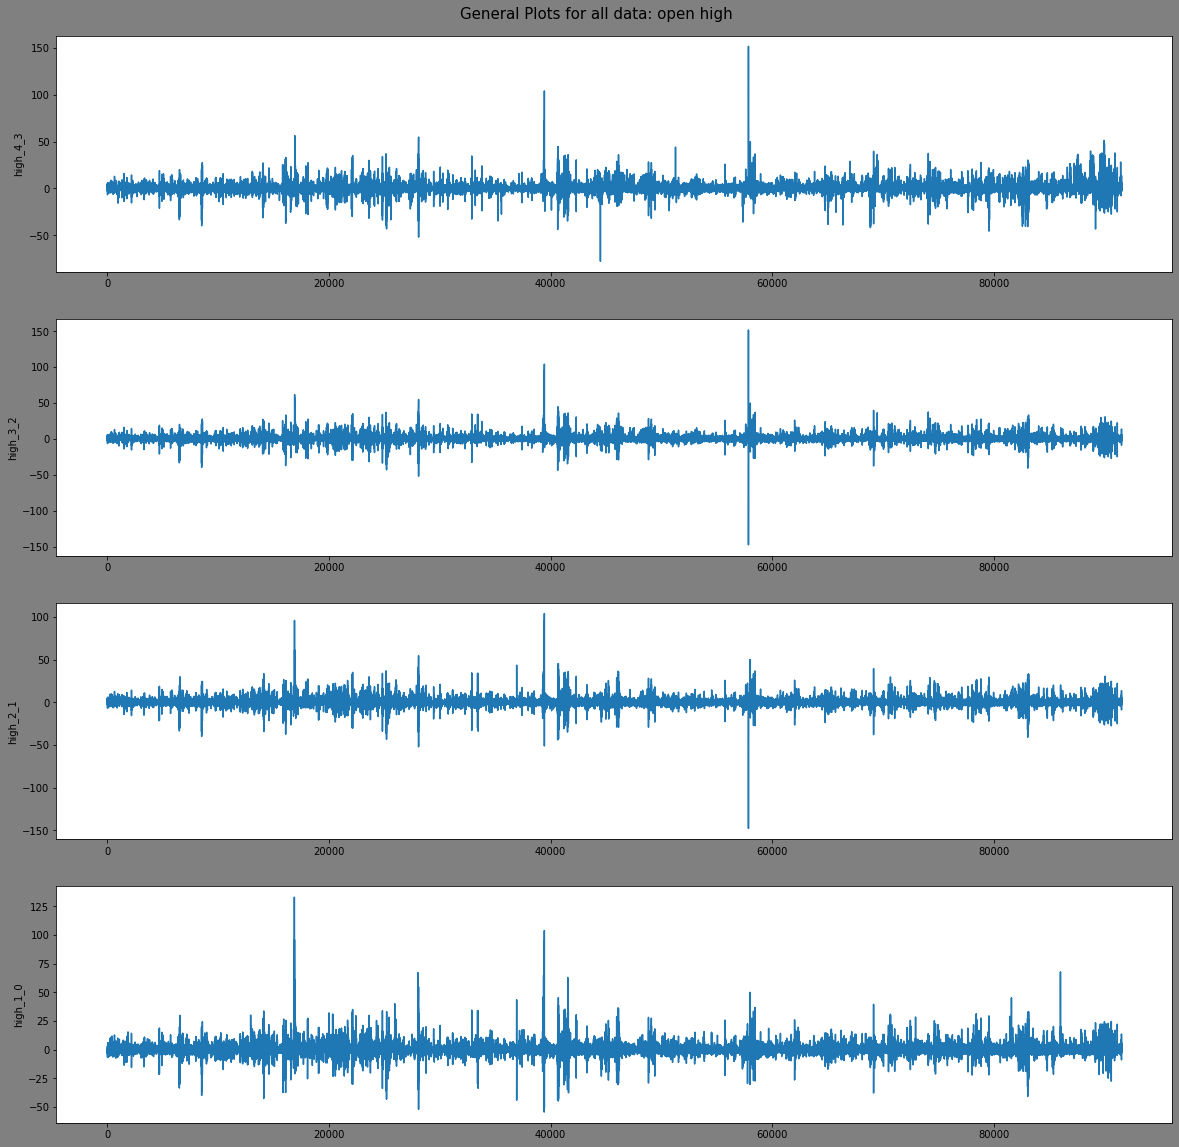

Plots for low:


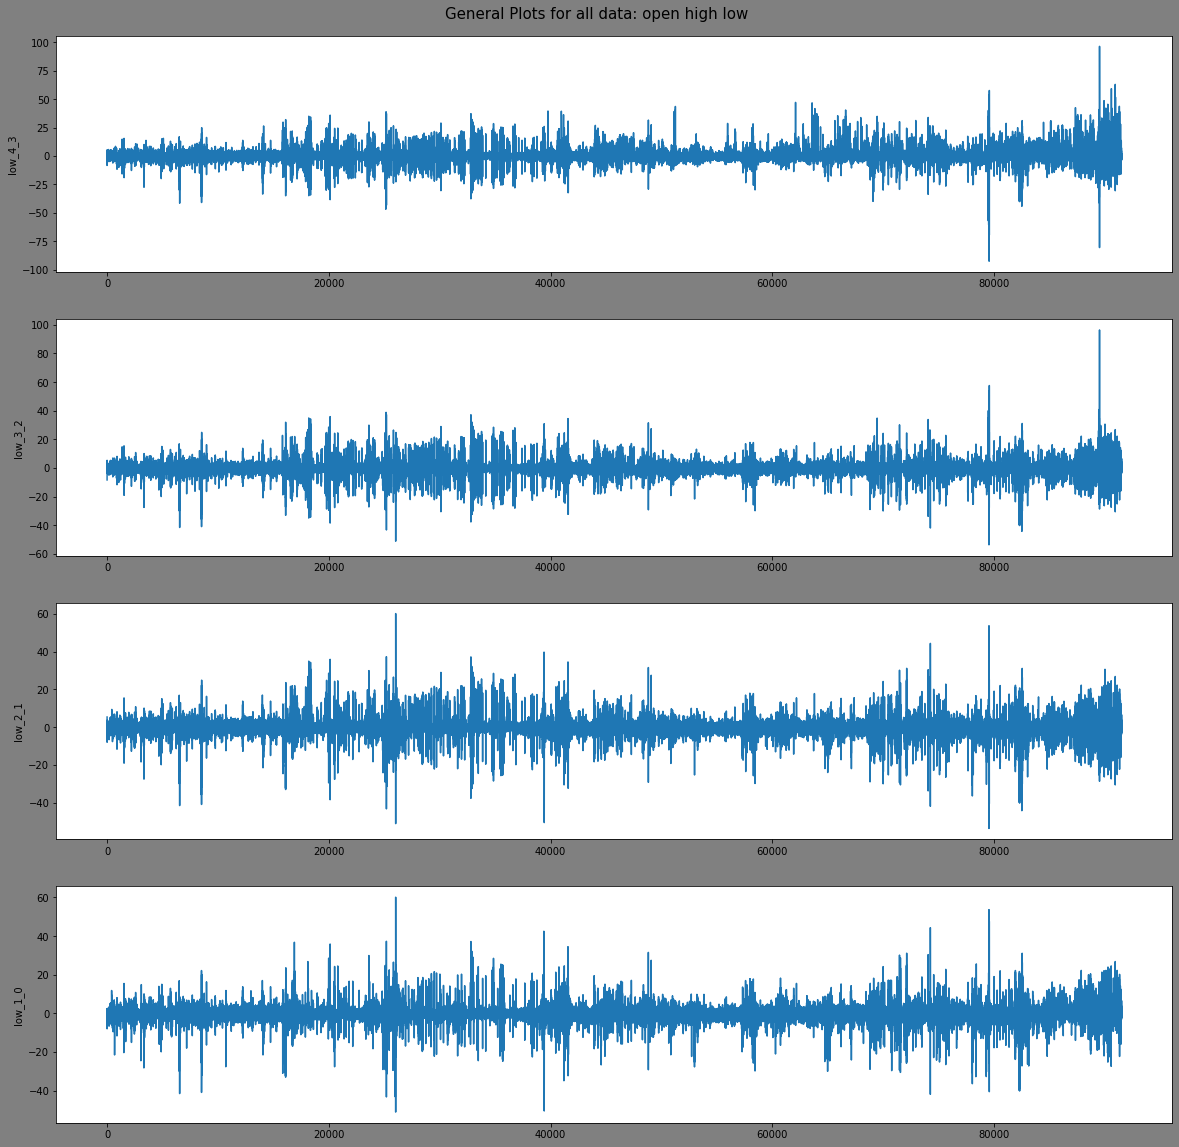

Plots for close:


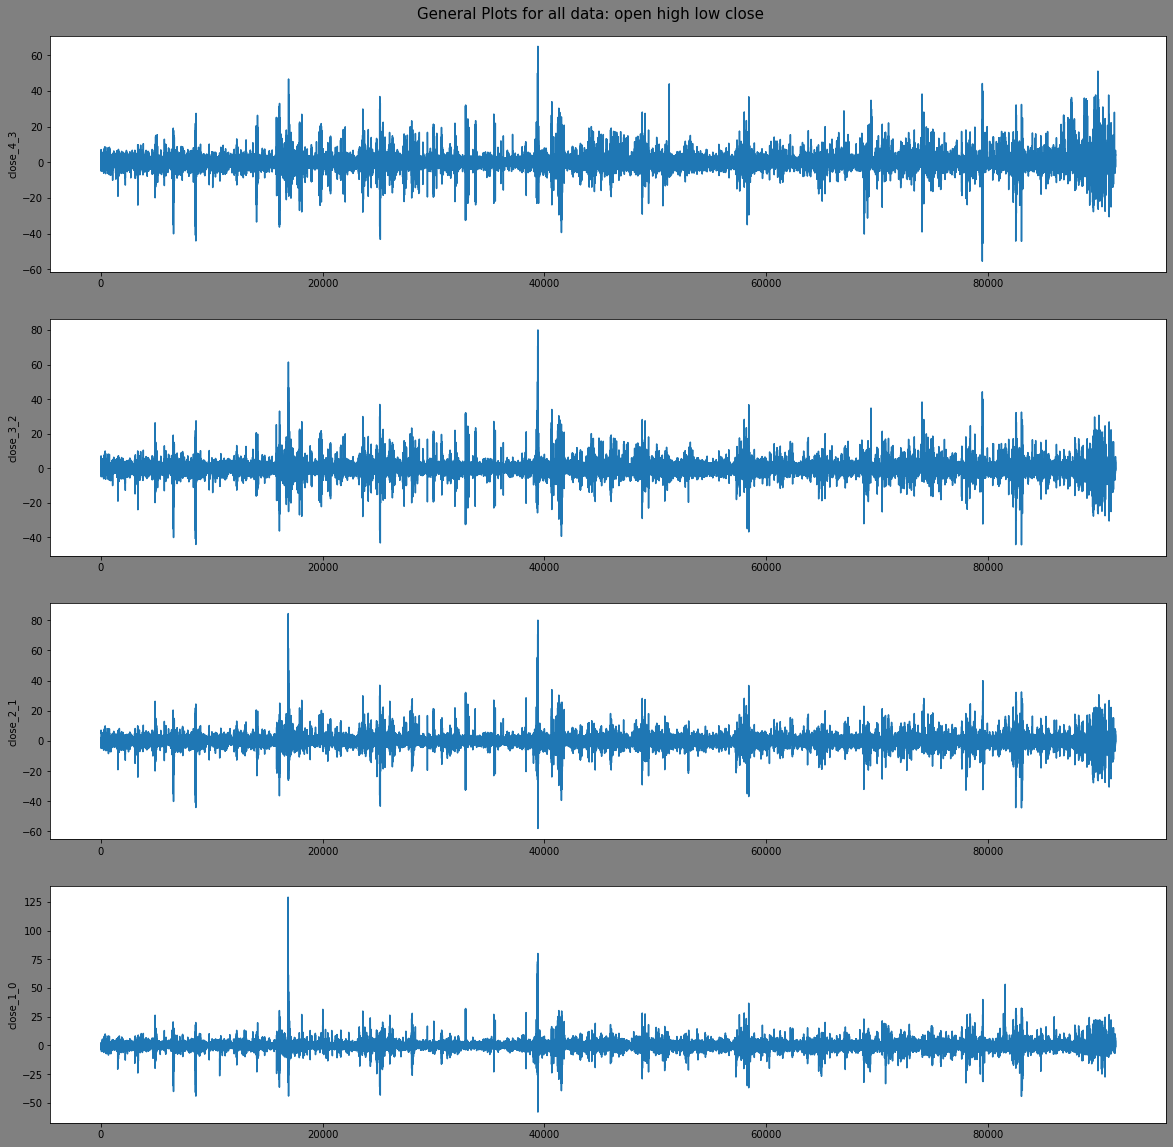

Plots for volume:


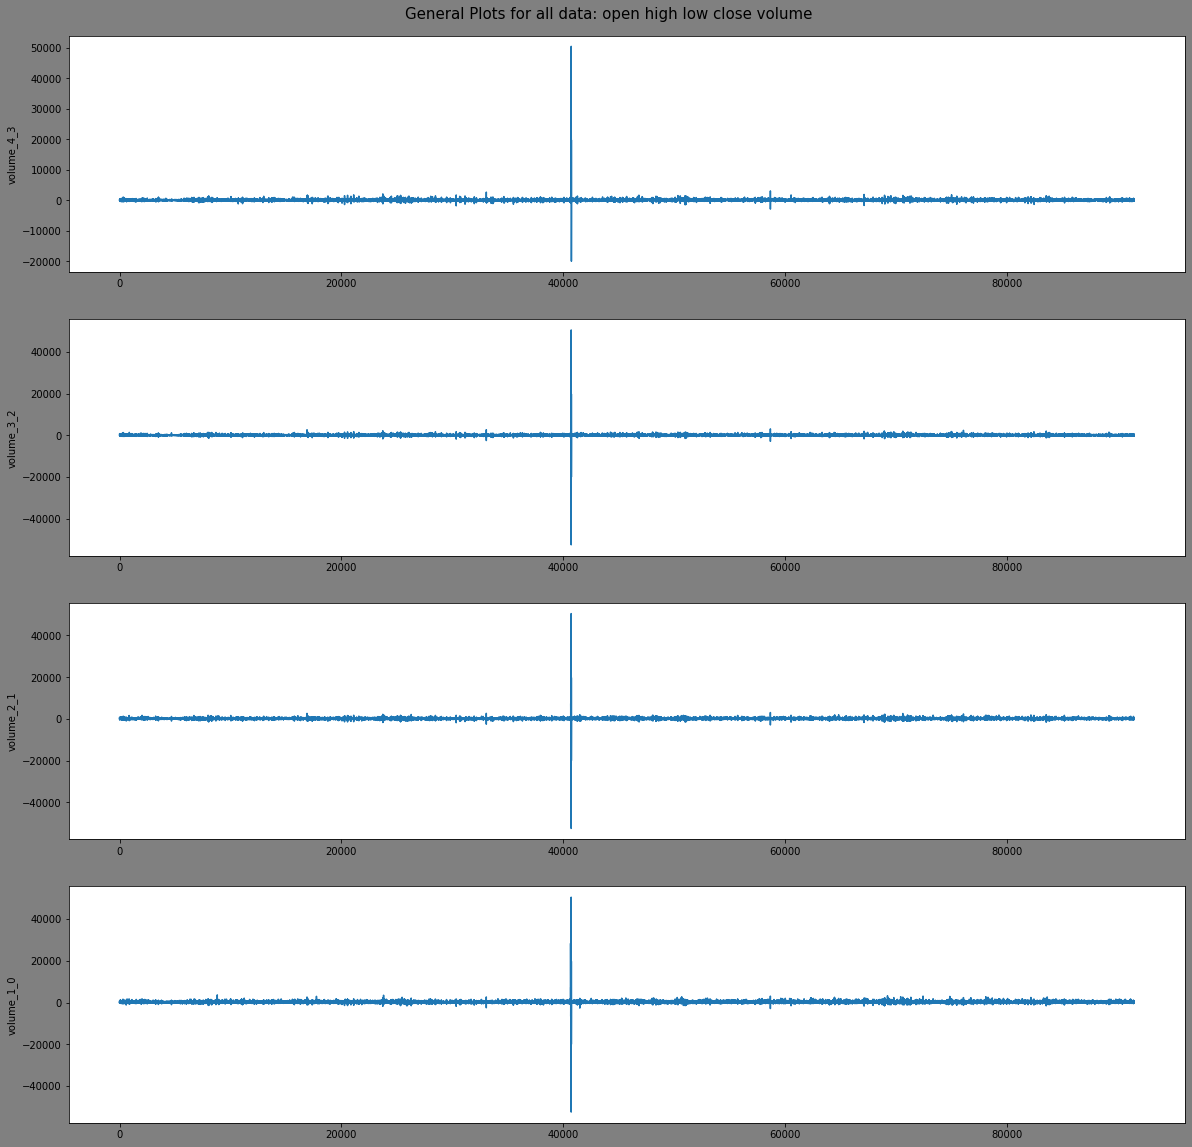

Plots for minutes:


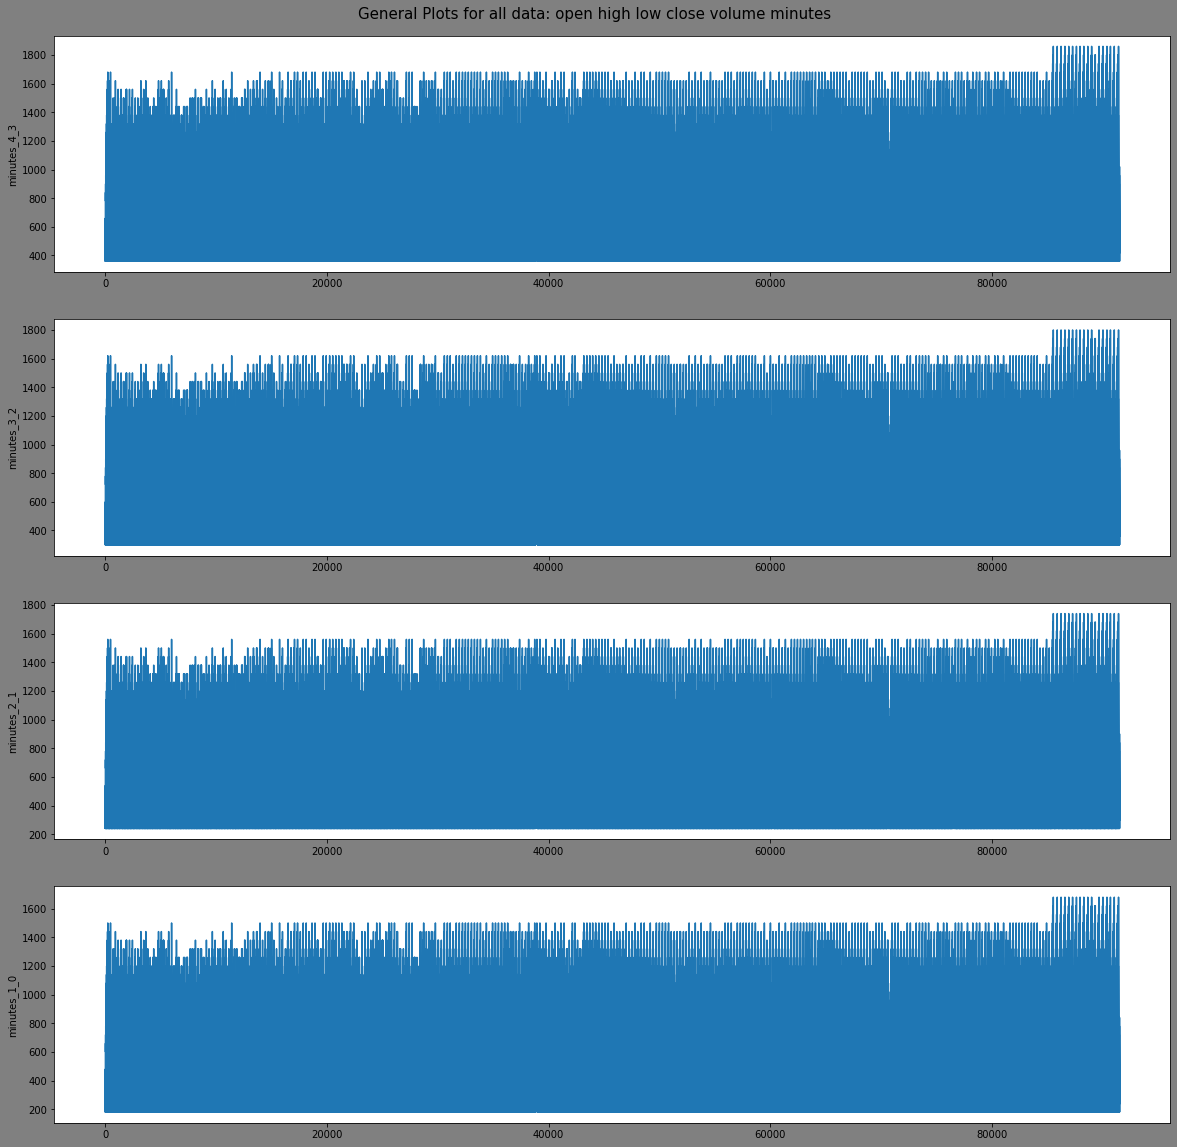

In [10]:
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for all data:"
plot_subplots_wrapper(df_to_plot, title)

Plots for open:


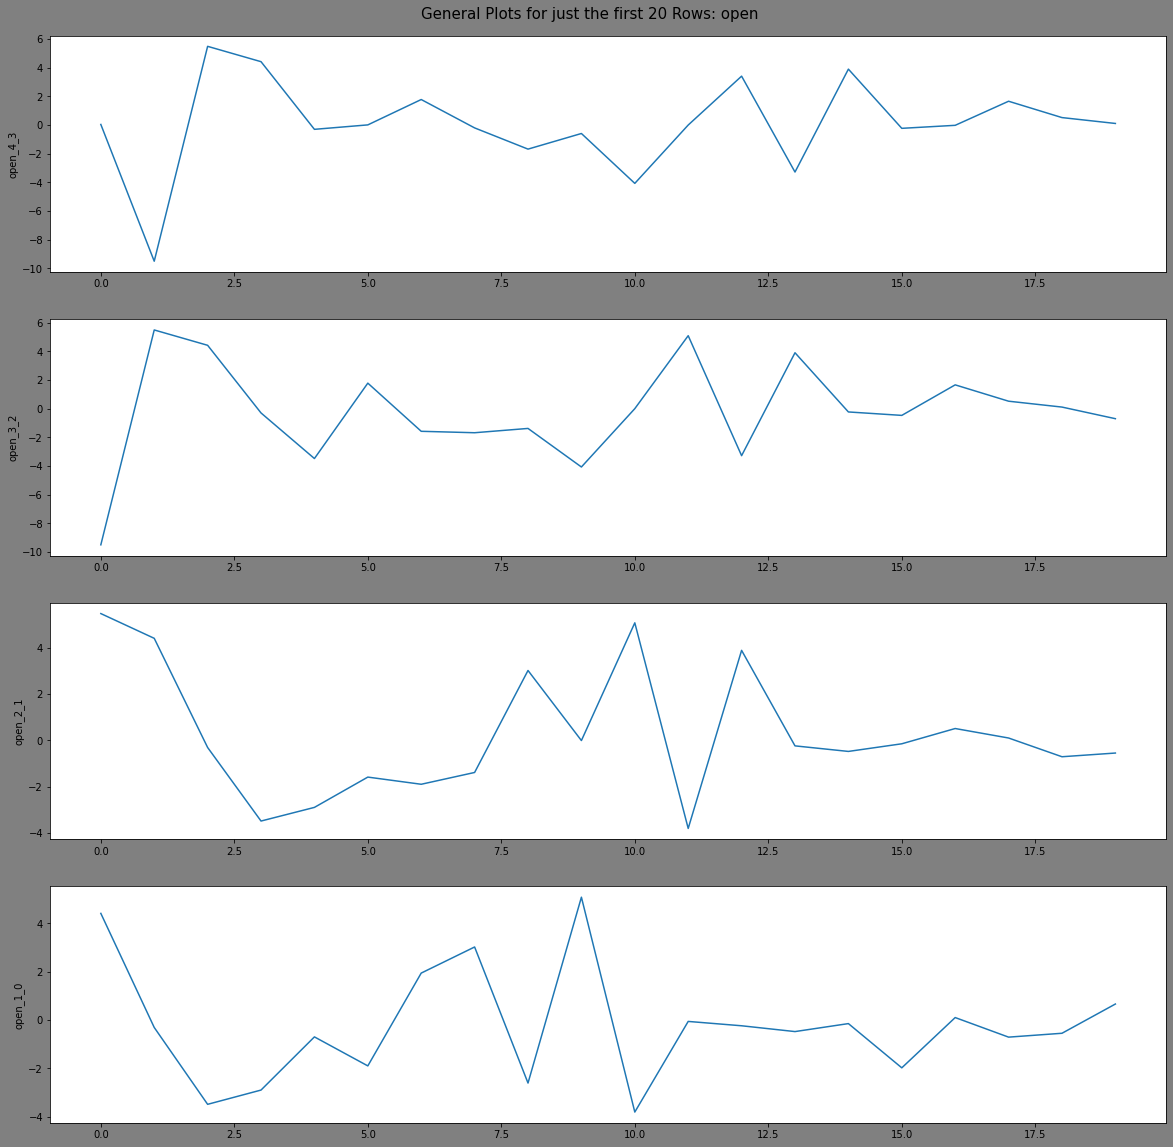

Plots for high:


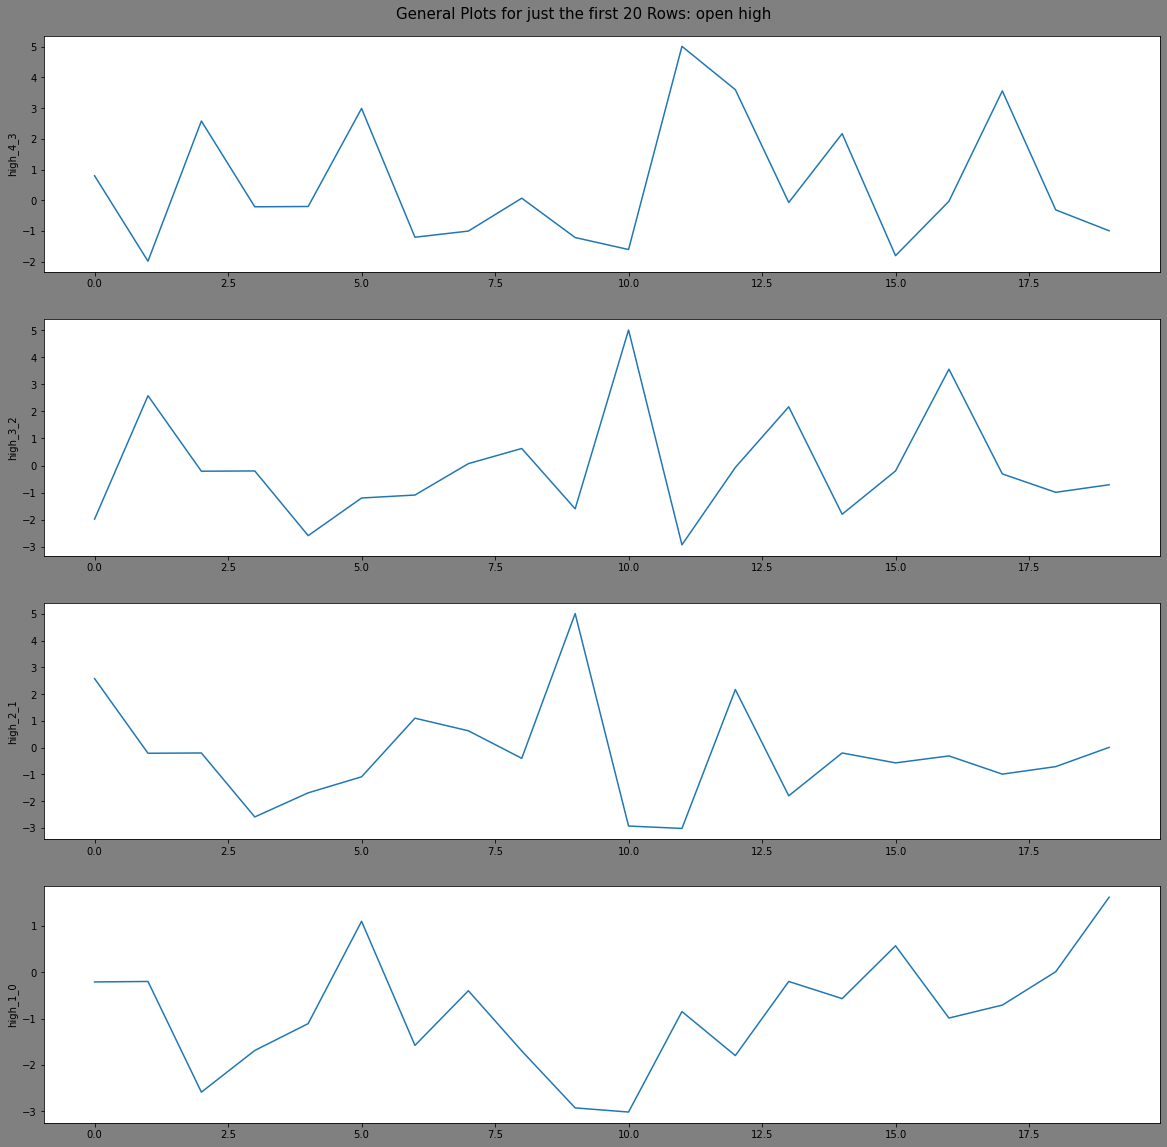

Plots for low:


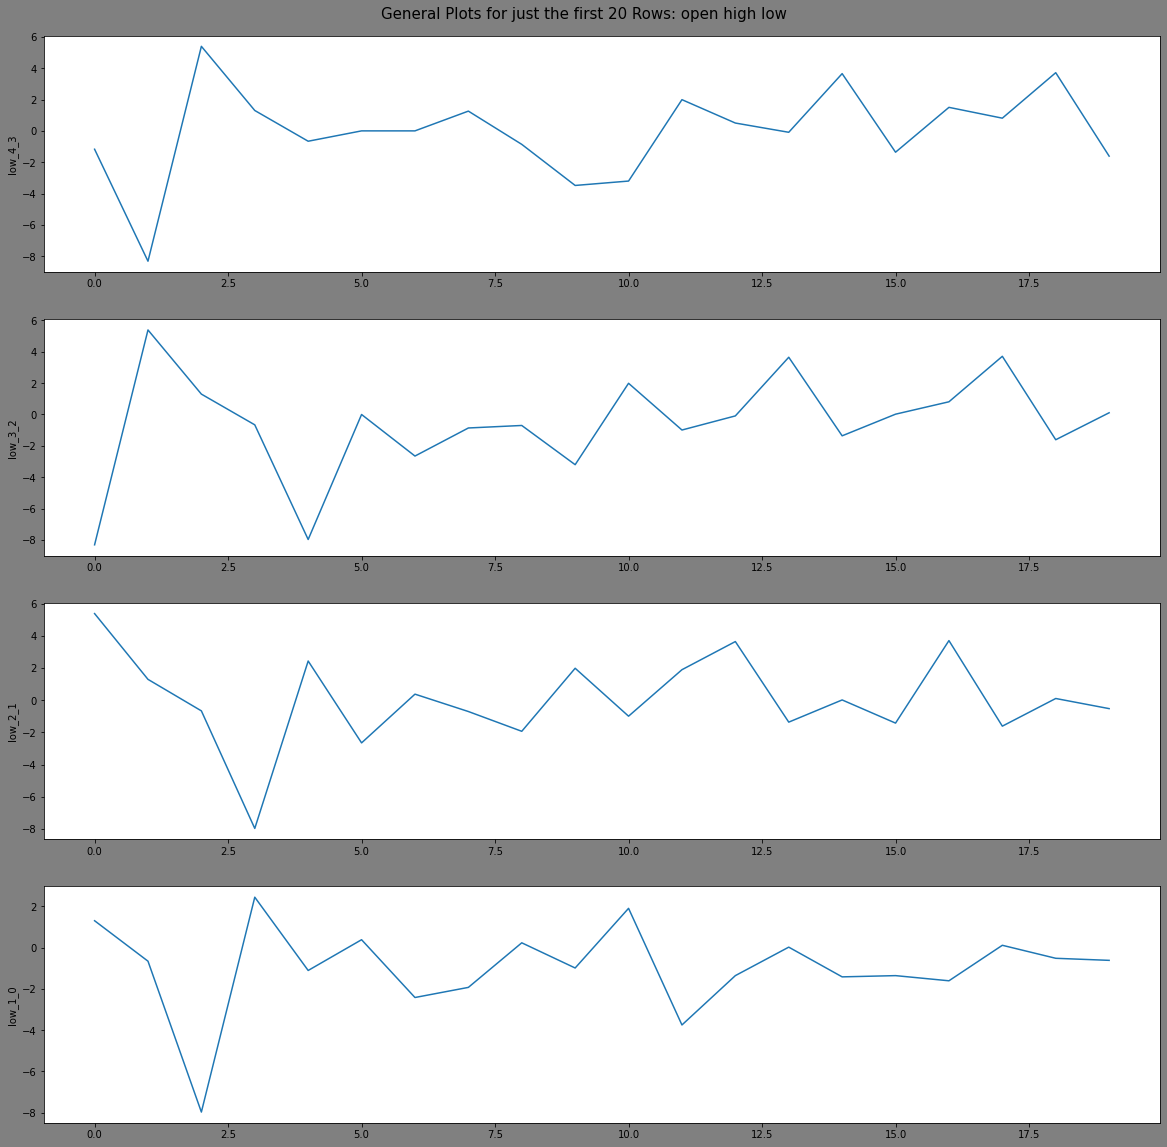

Plots for close:


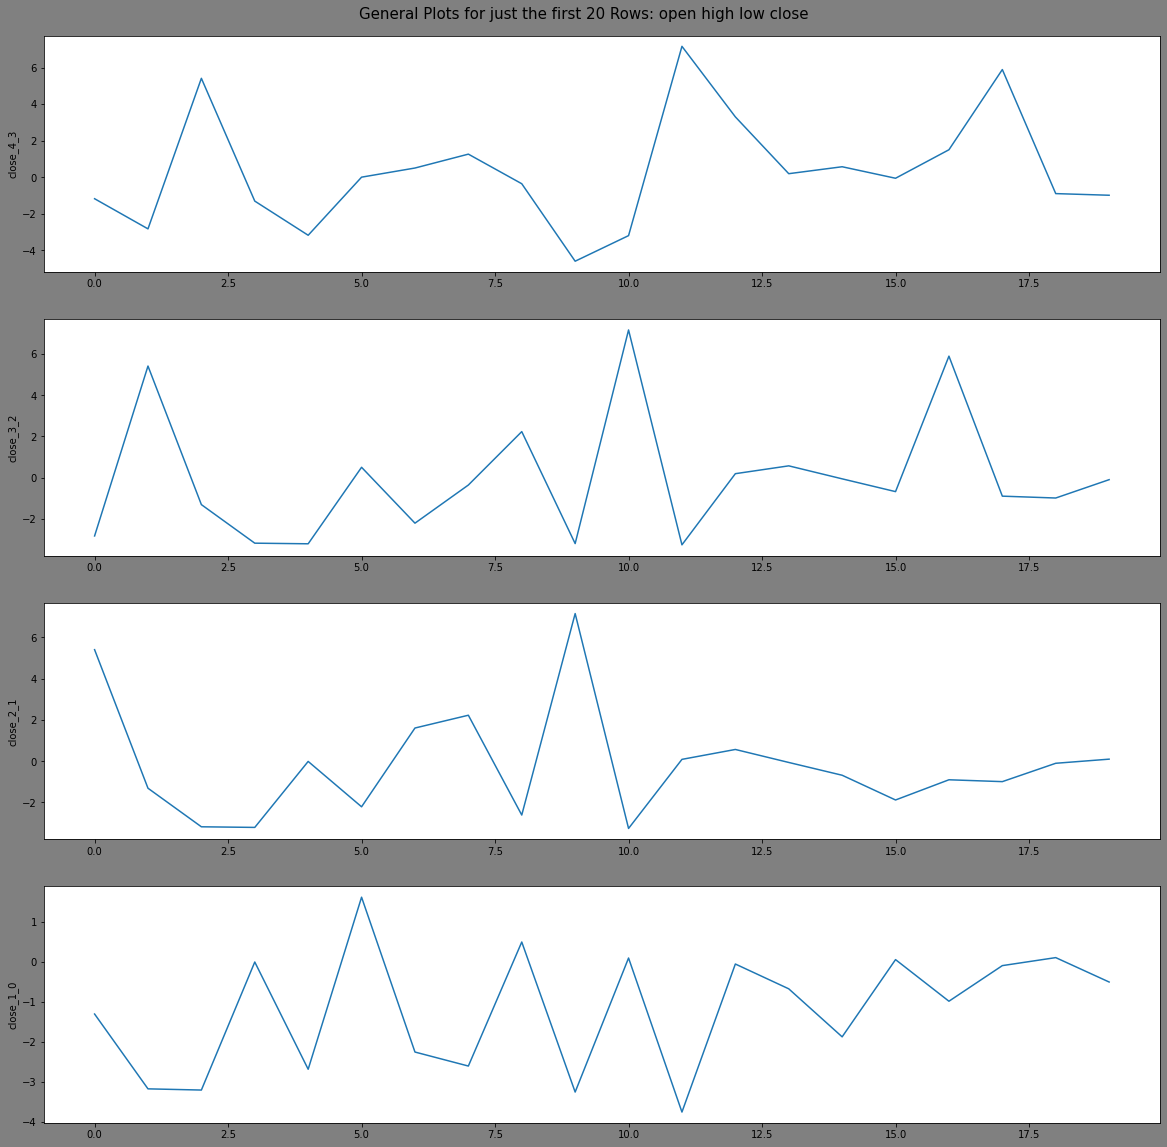

Plots for volume:


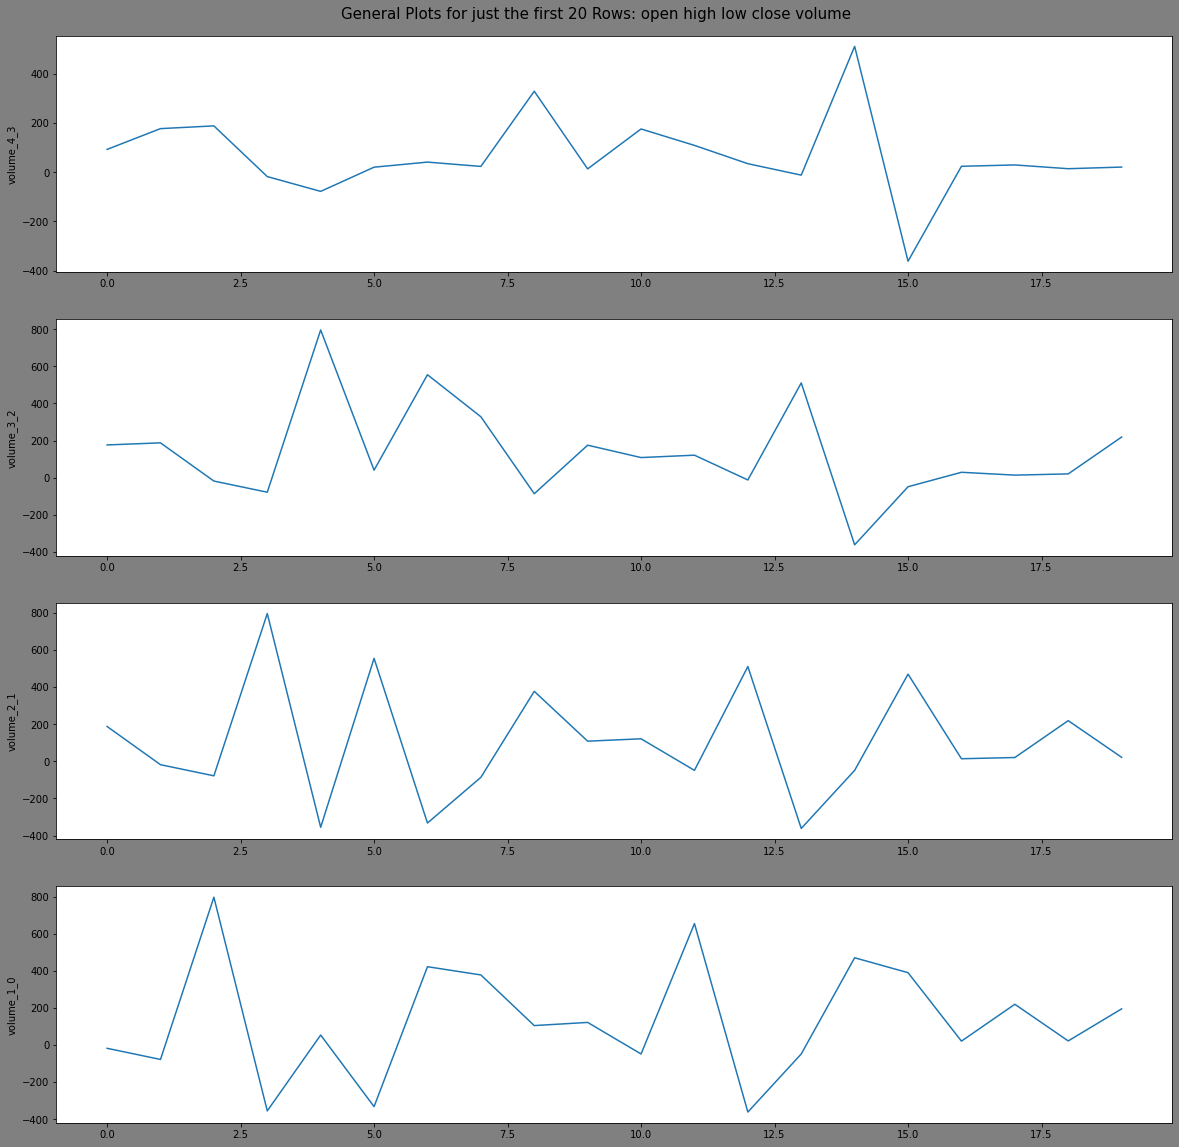

Plots for minutes:


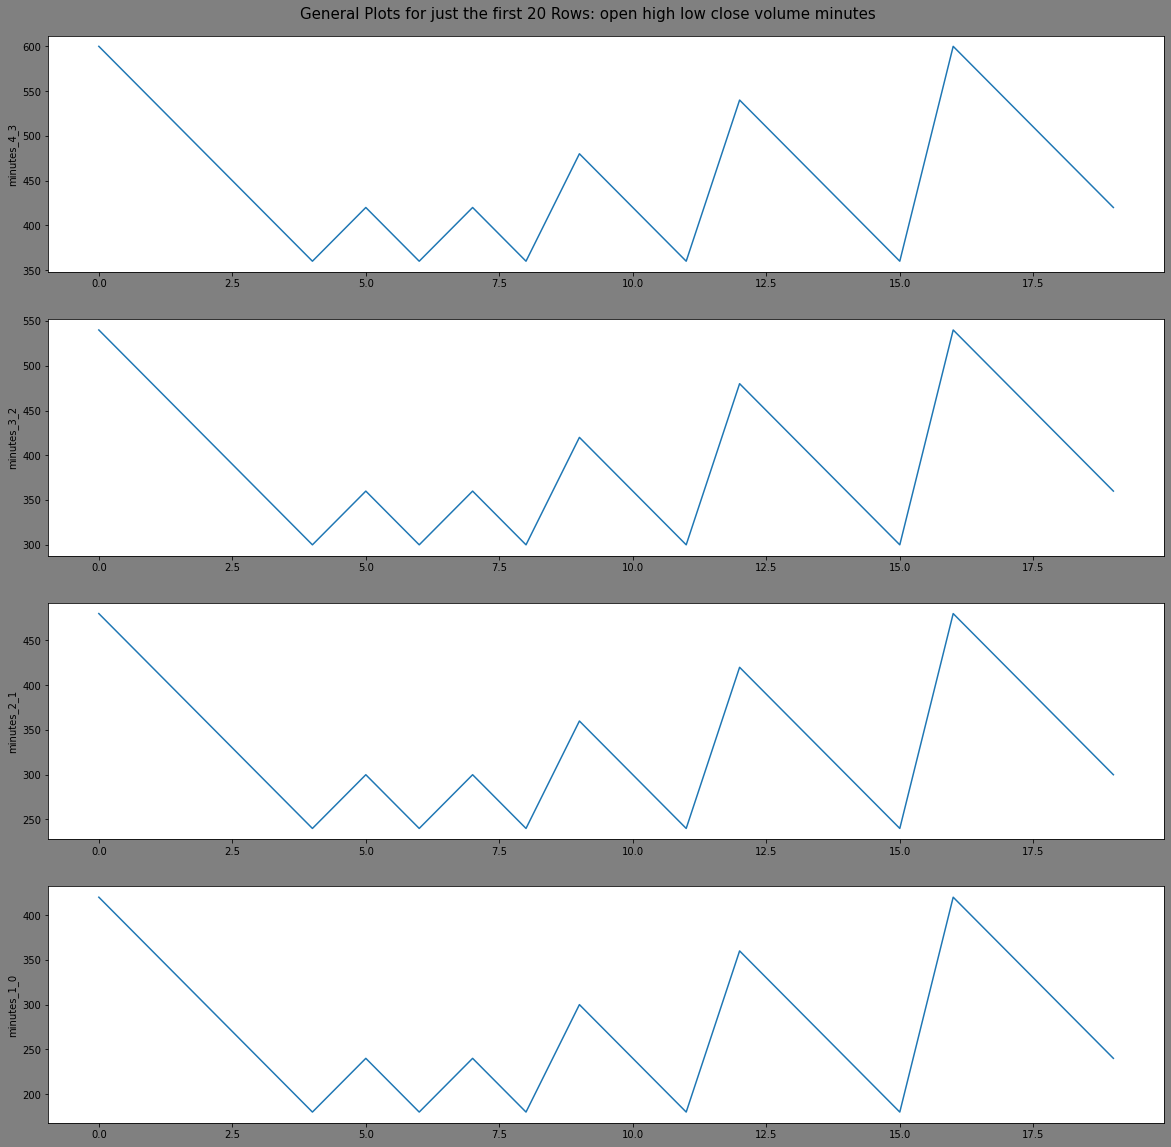

In [47]:
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for just the first 20 Rows:"
plot_subplots_wrapper(df_to_plot.iloc[:20, :].reset_index(), title)

## Correlation

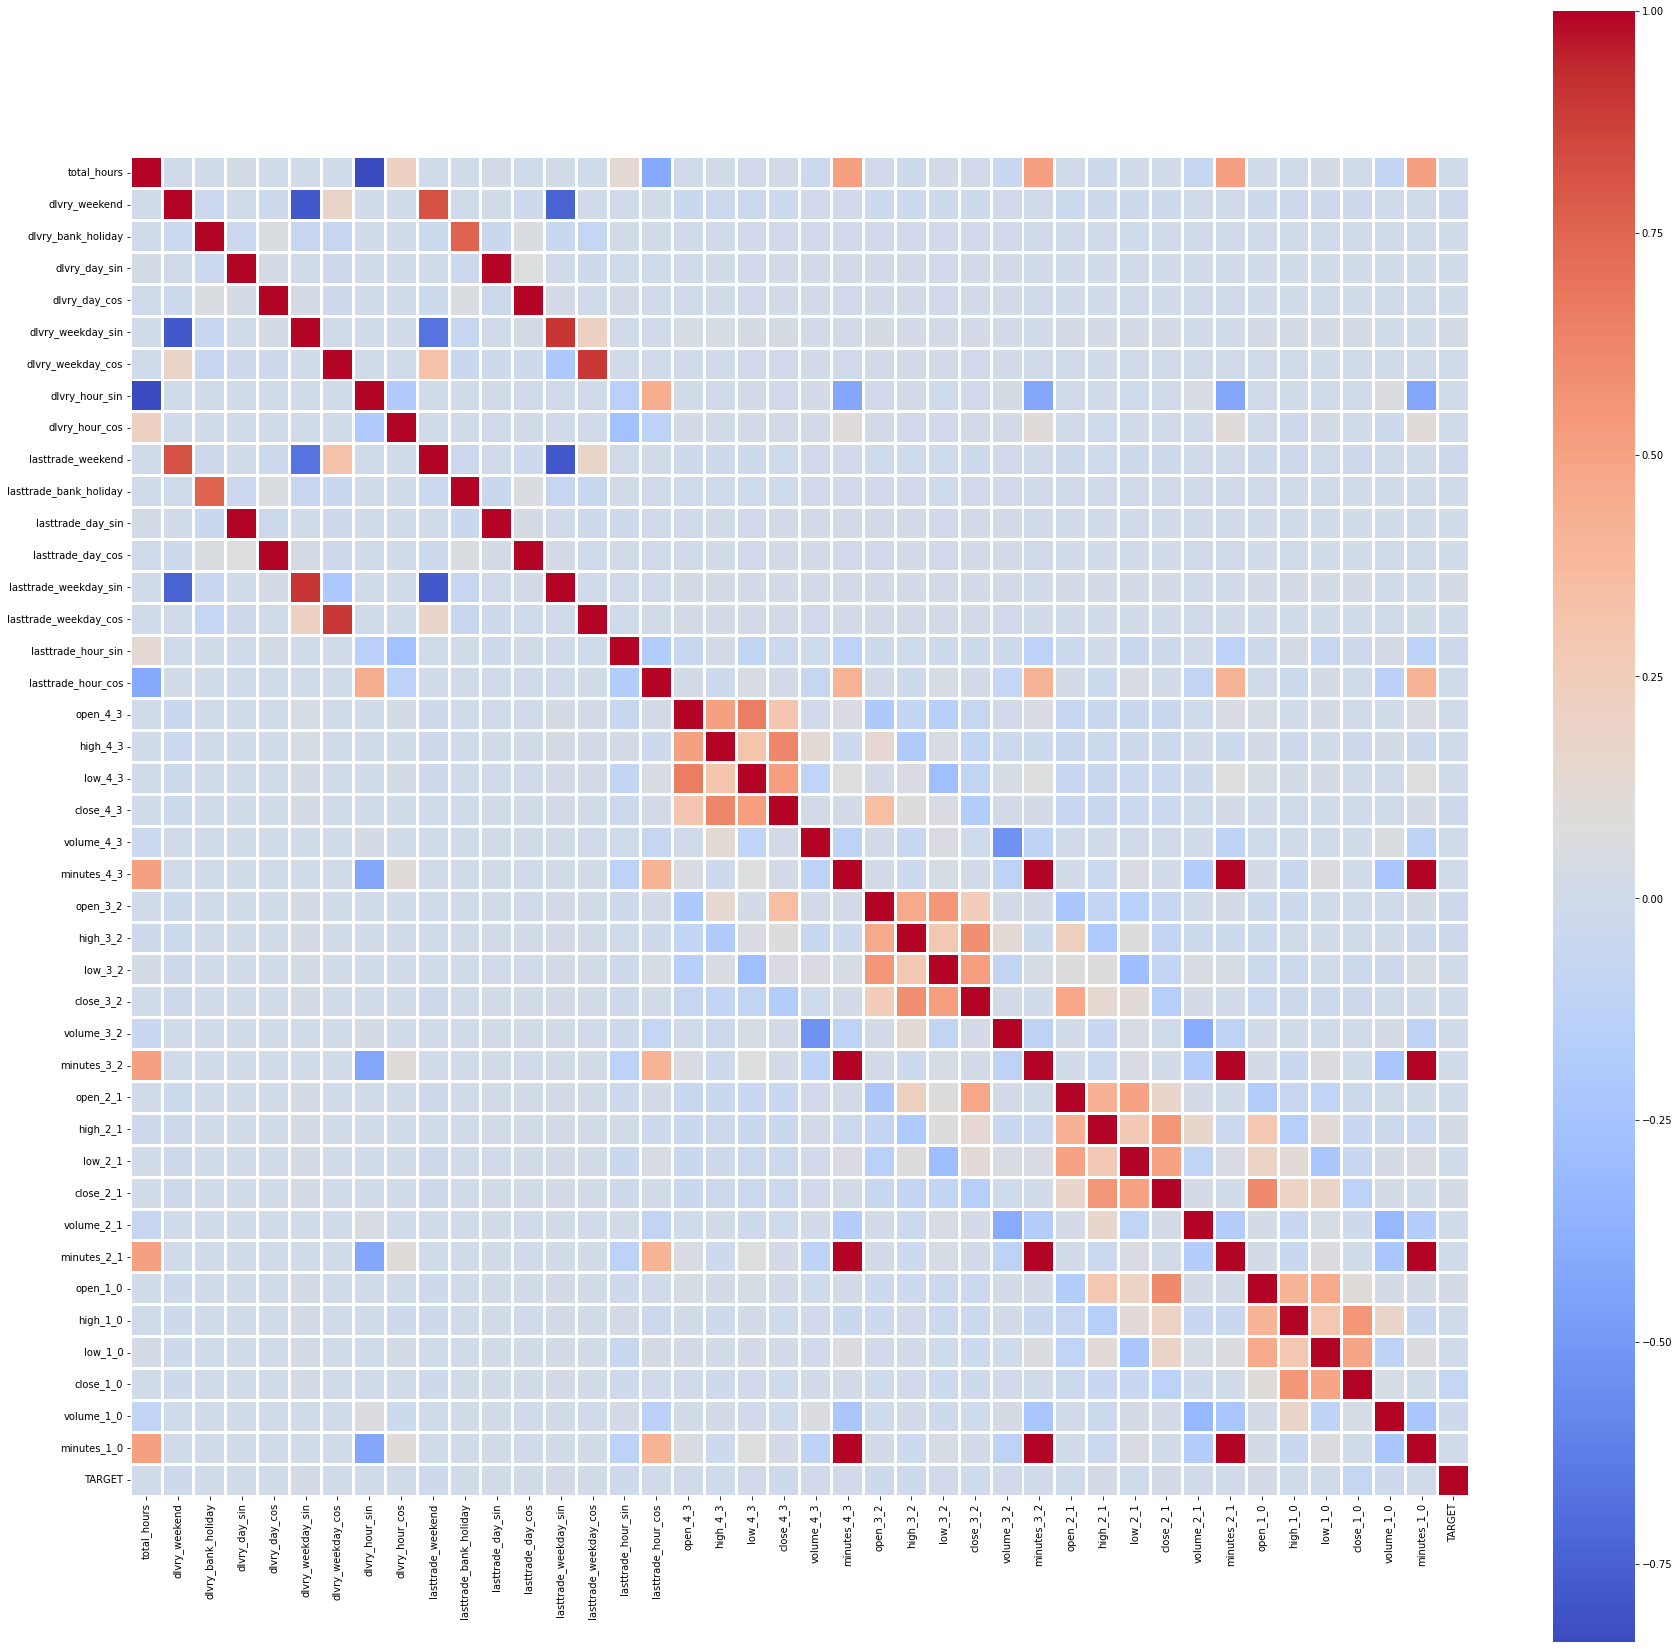

In [48]:
plt.figure(figsize=(30,30))
full_train_window_size_5 = X_train_window_size_5.copy()
full_train_window_size_5["TARGET"] = y_train_window_size_5["y"]
sns.heatmap(full_train_window_size_5.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

### The summary of the correlation matrix

# Creating Machine Learning models

## Preprocessing the data

### Normalization

In [8]:
scaler = MinMaxScaler()
X_train_window_size_5[X_train_window_size_5.columns[17:]] = scaler.fit_transform(X_train_window_size_5[X_train_window_size_5.columns[17:]])
X_valid_window_size_5[X_valid_window_size_5.columns[17:]] = scaler.transform(X_valid_window_size_5[X_valid_window_size_5.columns[17:]])
X_test_window_size_5[X_test_window_size_5.columns[17:]] = scaler.transform(X_test_window_size_5[X_test_window_size_5.columns[17:]])

#Quick note: It seems like the results are getting worse when normalizing the input set X

## Evaluation: Mean absolut error function

In [9]:
def evaluate_model(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    return mae

## Function for training modesl with parameter grids

In [12]:
def cross_validation_training(model, X_train, y_train, param_grid):
    CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                            scoring='neg_mean_absolute_error', n_jobs=-1,
                            verbose=3)
    CV_model.fit(X_train, y_train)
    print('The best combination of parameters is', CV_model.best_params_)
    
    model = model.set_params(**CV_model.best_params_)
    model.fit(X_train, y_train)
    return model

## Dummy regressor

In [14]:
dummy_model = DummyRegressor()

dummy_model.fit(X_train_window_size_5, y_train_window_size_5)

DummyRegressor()

In [15]:
result = evaluate_model(dummy_model, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.258751650277334


## Linear Regression

## ARIMA

## RandomForrest Regressor

In [ ]:
rfmodel = RandomForestRegressor(random_state=142, 
                                criterion='mae')

param_grid = {'max_depth': [8, 10],
              'n_estimators': [200, 500]}

rfmodel = cross_validation_training(rfmodel, X_train_window_size_5, 
                                    y_train_window_size_5, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
result = evaluate_model(rfmodel, X_test_window_size_5, y_test_window_size_5)

## Gradient Boosting on Decision Trees (CatBoost and XGB)

### XGBoost Model

In [102]:
dmatrix_train = xgb.DMatrix(data=X_train_window_size_5,label=y_train_window_size_5) 
dmatrix_valid = xgb.DMatrix(data=X_valid_window_size_5,label=y_valid_window_size_5)
dmatrix_test = xgb.DMatrix(data=X_test_window_size_5,label=y_test_window_size_5)

In [111]:
params = {'objective': 'reg:linear', 'eval_metric': 'mae', 'n_estimators': 100}
evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]
xg_reg = xgb.train(params = params, dtrain=dmatrix_train, num_boost_round=8, evals=evallist)

[10:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:2.61513	train-mae:1.83455
[1]	eval-mae:2.60096	train-mae:1.80634
[2]	eval-mae:2.59028	train-mae:1.78905
[3]	eval-mae:2.58278	train-mae:1.77601
[4]	eval-mae:2.57963	train-mae:1.76601
[5]	eval-mae:2.57684	train-mae:1.76067
[6]	eval-mae:2.57773	train-mae:1.75736
[7]	eval-mae:2.57756	train-mae:1.75216


In [112]:
result = evaluate_model(xg_reg, dmatrix_test, dmatrix_test.get_label())

Mean absolut error on test: 2.2897794


## Support Vector Machine Regression

In [13]:
svrmodel = SVR()

param_grid = {'kernel': ['rbf', 'poly'],
              'C': [10, 20]}

svrmodel = cross_validation_training(svrmodel, X_train_window_size_5, 
                                     y_train_window_size_5, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed: 19.0min remaining: 76.1min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 20.2min remaining: 16.5min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 37.7min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 37.8min finished


The best combination of parameters is {'C': 20, 'kernel': 'poly'}


In [14]:
result = evaluate_model(svrmodel, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.2600599513471384


# Creating Deep Learning Models

## Preprocessing the data to 3D for Recurrent Neural Networks

## Mulit-Layer Perceptron

## Convolutional Neural Network

## Recurrent Neural Network

### LSTM: Long-Short-Term Memory

### Gated recurrent unit

## Transformers: Attention is all you need!